# German Speed Limit Sign Recognition with Tensorflow and Keras

In [1]:
%matplotlib inline
%pylab inline

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Installation of required libs Scikit Learn, TensorFlow, and Keras

In [3]:
!conda install --name root scikit-learn -y

Fetching package metadata .........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be UPDATED:

    mkl:          11.3.3-0           --> 2017.0.1-0        
    numexpr:      2.6.0-np111py35_0  --> 2.6.2-np111py35_0 
    numpy:        1.11.0-py35_2      --> 1.11.3-py35_0     
    scikit-learn: 0.17.1-np111py35_2 --> 0.18.1-np111py35_1
    scipy:        0.17.1-np111py35_1 --> 0.19.0-np111py35_0

mkl-2017.0.1-0 100% |################################| Time: 0:00:02  67.04 MB/s
numpy-1.11.3-p 100% |################################| Time: 0:00:00  56.43 MB/s
numexpr-2.6.2- 100% |################################| Time: 0:00:00  51.83 MB/s
scipy-0.19.0-n 100% |################################| Time: 0:00:00  60.60 MB/s
scikit-learn-0 100% |################################| Time: 0:00:00  60.36 MB/s


In [4]:
from distutils.version import StrictVersion

In [5]:
import sklearn

# should at least be 0.18
assert StrictVersion(sklearn.__version__ ) >= StrictVersion('0.18.1')

sklearn.__version__

'0.18.1'

In [6]:
!conda install --name root -c conda-forge tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following NEW packages will be INSTALLED:

    mock:       2.0.0-py35_0  conda-forge
    pbr:        2.1.0-py35_0  conda-forge
    protobuf:   3.2.0-py35_0  conda-forge
    tensorflow: 1.0.0-py35_0  conda-forge

The following packages will be SUPERSEDED by a higher-priority channel:

    conda:      4.3.16-py35_0             --> 4.2.13-py35_0 conda-forge
    conda-env:  2.6.0-0                   --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.18 MB/s
conda-4.2.13-p 100% |################################| Time: 0:00:00   1.36 MB/s
protobuf-3.2.0 100% |################################| Time: 0:00:00  16.09 MB/s
pbr-2.1.0-py35 100% |################################| Time: 0:00:00  43.49 MB/s
mock-2.0.0-py3 100% |################################| Time: 0:00:00  33.74 MB/s
tensorflow-1

In [7]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# should at least be 1.0
assert StrictVersion(tf.__version__) >= StrictVersion('1.0.0')

tf.__version__

'1.0.0'

In [8]:
!pip install keras

    100% |################################| 204kB 3.0MB/s ta 0:00:01
    100% |################################| 3.1MB 456kB/s eta 0:00:01-1 day, 23:59:59
  Running setup.py bdist_wheel for keras ... - \ done
  Stored in directory: /home/nbuser/.cache/pip/wheels/93/72/65/4924fd6b1859343291c50774e2df36919ee61c4511dc6a9890
  Running setup.py bdist_wheel for theano ... - \ | / - done
  Stored in directory: /home/nbuser/.cache/pip/wheels/d5/5b/93/433299b86e3e9b25f0f600e4e4ebf18e38eb7534ea518eba13
Successfully built keras theano
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import keras as keras

# should at least be 1.2 and use TensorFlow backend
assert StrictVersion(keras.__version__) >= StrictVersion('1.2.2')

keras.__version__

Using TensorFlow backend.


'2.0.3'

## Download data

In [10]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  2702k      0 --:--:-- --:--:-- --:--:-- 2701k


In [11]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

## Prepare Image Data

In [12]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [13]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [14]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [15]:
import numpy as np

y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))

## Training using alternative architectures

In [16]:
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

In [17]:
from sklearn.model_selection import train_test_split

### Split training (80%) from test data (%20) (and make it reproduceable)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### Deep Residual networks using shortcut layers

In [95]:
# https://arxiv.org/abs/1512.03385
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import ZeroPadding2D, BatchNormalization, AveragePooling2D

inputs = Input(shape=(64, 64, 3))

# prep
x = ZeroPadding2D((3, 3))(inputs)
x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = BatchNormalization(axis=3, name='bn_conv1')(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

# conv block 1, shortcut with conv layer
input_tensor = x

x = Conv2D(64, (1, 1), strides=(1, 1),
           name='conv_1a')(input_tensor)
x = BatchNormalization(axis=3, name='batch_1a')(x)
x = Activation('relu')(x)

x = Conv2D(64, 3, padding='same',
           name='conv_1b')(x)
x = BatchNormalization(axis=3, name='batch_1b')(x)
x = Activation('relu')(x)

x = Conv2D(256, (1, 1), name='conv_1c')(x)
x = BatchNormalization(axis=3, name='batch_1c')(x)

shortcut = Conv2D(256, (1, 1), strides=(1,1),
                  name='shortcut1')(input_tensor)
shortcut = BatchNormalization(axis=3, name='batch1')(shortcut)

x = keras.layers.add([x, shortcut])
x = Activation('relu')(x)

# identity block 1, shortcut without conv layer
input_tensor = x

x = Conv2D(64, (1, 1), name='conv_2a')(input_tensor)
x = BatchNormalization(axis=3, name='batch_2a')(x)
x = Activation('relu')(x)

x = Conv2D(64, 3,
           padding='same', name='conv_2b')(x)
x = BatchNormalization(axis=3, name='batch_2b')(x)
x = Activation('relu')(x)

x = Conv2D(256, (1, 1), name='conv_2c')(x)
x = BatchNormalization(axis=3, name='batch_2c')(x)

x = keras.layers.add([x, input_tensor])
x = Activation('relu')(x)

# identity block 2, shortcut without conv layer
input_tensor = x

x = Conv2D(64, (1, 1), name='conv_3a')(input_tensor)
x = BatchNormalization(axis=3, name='batch_3a')(x)
x = Activation('relu')(x)

x = Conv2D(64, 3,
           padding='same', name='conv_3b')(x)
x = BatchNormalization(axis=3, name='batch_3b')(x)
x = Activation('relu')(x)

x = Conv2D(256, (1, 1), name='conv_3c')(x)
x = BatchNormalization(axis=3, name='batch_3c')(x)

x = keras.layers.add([x, input_tensor])
x = Activation('relu')(x)

# there could be many more blocks

# final stage
x = AveragePooling2D((7, 7), name='avg_pool')(x)
x = Flatten()(x)
# no final fc in original approach
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.50)(x)

predictions = Dense(6, activation='softmax')(x)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=predictions)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
# you need a bit of luck, but should learn quite fast and eventually come to 100%
model.fit(X_train, y_train, nb_epoch=50, batch_size=32)

Epoch 1/100
303/303 [==============================] - 5s - loss: 3.3617 - acc: 0.1848      
Epoch 2/100
303/303 [==============================] - 4s - loss: 1.9625 - acc: 0.3069     

KeyboardInterrupt: 

In [98]:
# again, if accuracy is still not close to 1, run this as many times as necessary 
model.fit(X_train, y_train, nb_epoch=10, batch_size=32)

Epoch 1/10
303/303 [==============================] - 4s - loss: 2.5013e-04 - acc: 1.0000     
Epoch 2/10
303/303 [==============================] - 4s - loss: 1.5097e-04 - acc: 1.0000     

In [99]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 4s     


(0.056037483853672201, 0.98679867986798675)

In [100]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

76/76 [==============================] - 0s     


(0.25929030932878194, 0.9342105231787029)

## Very high accuracy even for test data, very promising

### Let us try a few random samples on the test data

In [101]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make this deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [102]:
sample_labels

[array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.])]

In [103]:
# that is a tad hard to read, just choose the category

ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([5, 2, 2, 0, 1, 1, 2, 3, 5, 2])

In [104]:
# now make the prediction for the sample inputs
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)

In [105]:
# softmax predictions would be even harder to read, again just choose the hightst category

predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([5, 2, 2, 0, 1, 1, 2, 0, 5, 2])

In [106]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

## Visualizing where we were right (might be up to 9 out of 10)

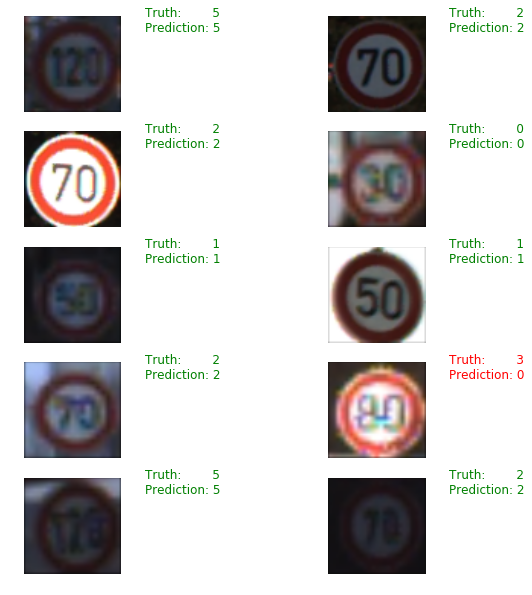

In [107]:
display_prediction(sample_images, ground_truth, predicted_categories)

## Save model for later predictions and comparions

In [108]:
!mkdir models

mkdir: cannot create directory 'models': File exists


In [109]:
# model.save('models/conv-residual-final-fc.h5')
model.save('models/conv-residual.h5')

In [110]:
# use the Data Menu Item to download from this directory
!ls -l models

total 118488
-rw-r--r-- 1 nbuser nbuser 119320432 Apr 26 10:00 conv-residual-final-fc.h5
-rw-r--r-- 1 nbuser nbuser   2010088 Apr 26 10:40 conv-residual.h5


In [111]:
# https://notebooks.azure.com/faq#download_data
# or use https://transfer.sh/
# !curl --upload-file ./models/conv-residual-final-fc.h5 https://transfer.sh/conv-residual-final-fc.h5

In [112]:
# https://notebooks.azure.com/faq#download_data
# or use https://transfer.sh/
!curl --upload-file ./models/conv-residual.h5 https://transfer.sh/conv-residual.h5

https://transfer.sh/ldleM/conv-residual.h5